## Program Code for Calculating I(Qd)

### *1. Load module*

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from RW_NN_ext import IQ_gen_NN_cpu

2024-10-15 09:47:39.989497: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-15 09:47:40.085146: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-15 09:47:40.089631: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /SNS/software/lib64:/SNS/software/lib:/usr/lib64/gstreamer-0.10:/SNS/software/lib64:

tensorflow version = 2.10.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5590099547805314587
xla_global_id: -1
]
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_de (Dense)            (None, 3024)              12096     
                                                                 
 reshape_1 (Reshape)         (None, 63, 48)            0         
                                                                 
 conv1dtrs_de (Conv1DTranspo  (None, 126, 48)          11568     
 se)                                                             
                                                                 
 conv1d_transpose (Conv1DTra  (None, 126, 1)           241       
 nspose)                                                         
                                                                 
 reshape_2 (Reshape)      

2024-10-15 09:47:43.246447: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-15 09:47:43.306394: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /SNS/software/lib64:/SNS/software/lib:/usr/lib64/gstreamer-0.10:/SNS/software/lib64:/SNS/software/lib:/usr/lib64/gstreamer-0.10:/SNS/software/lib64:/SNS/software/lib:/usr/lib64/gstreamer-0.10:/opt/thinlinc/lib64:/opt/thinlinc/lib
2024-10-15 09:47:43.306465: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerro

### *2. Setup input parameters when generating training set*

As the NN only generates I(Q) on fixed Q-point, here we defines the original Q points used in generating the training set data.

In [2]:
box_size = 2
n_grid_scale = 256
dq = 2*np.pi/box_size
qq = np.arange(n_grid_scale/2)*dq
qq_data = qq[1:-1]
q = qq_data/20/np.pi

### *3. Pick up a set of parameters and generate the corresponding I(Q)*

Noted that the sigma_k used here is 20 times grater than demonstrated in the paper since the mean wavelength is set to 1/20 the box size to improve sampling.

In [3]:
params = np.array([1, 32, 0])  # [sigma_k (*20), Gamma, alpha]
I_q = IQ_gen_NN_cpu(params)

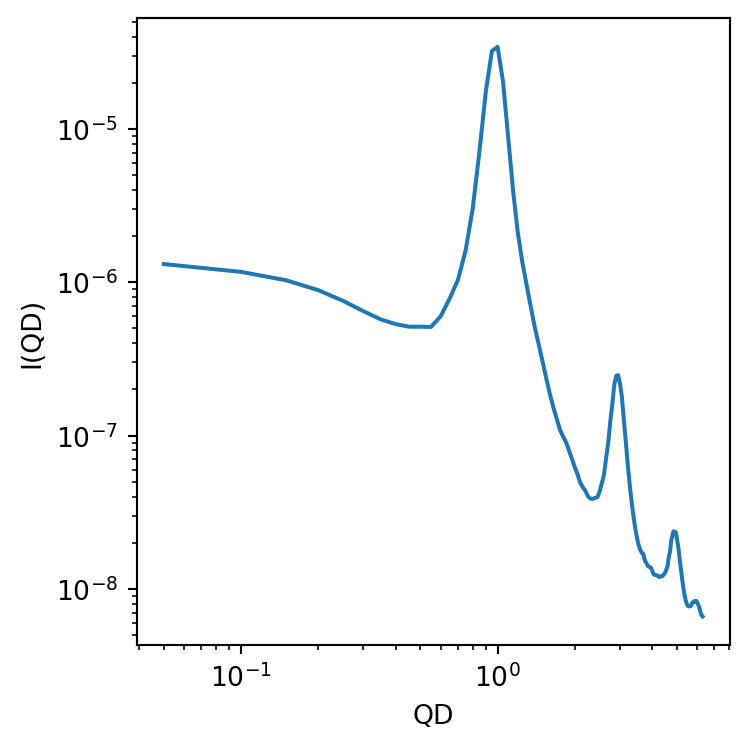

In [4]:
fig = plt.figure(figsize=(4, 4),dpi=192)
ax = plt.subplot(1,1,1)

ax.plot(q, I_q,'-')
ax.set_xlabel('QD')
ax.set_ylabel('I(QD)')
ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()

## Program Code for Computing the Three-Dimensional Structures in Fig. 1(c)

### *1. Load module*

The pyvista package is required for 3D visualization.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import os
import pyvista as pv

### *2. Evaluate randomwave on grid points*

In [6]:
## Define the grid
n_grid = 128
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(-1,1,n_grid+1)
z = np.linspace(-1,1,n_grid+1)

r_grid = np.meshgrid(x,y,z) 

In [7]:
#### Wave vector distribution ####
def sample_k(k_mean,k_cov):
    return np.random.multivariate_normal(k_mean,k_cov)

#### Superpositioning the random wave ####
def rotation_matrix(axis, phi):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(phi / 2.0)
    b, c, d = -axis * np.sin(phi / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

def sample_wave_MO(r_grid, k_mean, k_cov, n_wave = 100, kappa=1e8):
    """def sample_wave_MO(r_grid, k_mean, k_cov, n_wave=100, kappa=1e8):
    Generates a sample wave using a modified Ornstein-Uhlenbeck process.
    Parameters:
    r_grid (list of numpy.ndarray): A list of 3D coordinate grids.
    k_mean (numpy.ndarray): Mean vector for the wave vector sampling.
    k_cov (numpy.ndarray): Covariance matrix for the wave vector sampling.
    n_wave (int, optional): Number of waves to sample. Default is 100.
    kappa (float, optional): Concentration parameter for the von Mises-Fisher distribution. Default is 1e8.
    Returns:
    numpy.ndarray: The generated wave sample.
    References:
    - https://en.wikipedia.org/wiki/Von_Mises%E2%80%93Fisher_distribution
    - https://doi.org/10.1080/03610919408813161"""
        
    rho = np.zeros_like(r_grid[0])
    r_grid = [r.astype(np.float32) for r in r_grid]
    for i in range(n_wave):
        phi = np.random.rand()*2*np.pi # random phase
        k_sample = sample_k(k_mean,k_cov)

        # misorientation
        sigma = 1e-6
        xi = np.random.rand()
        theta = np.random.rand()*2*np.pi
        W = 1+1/kappa*(np.log(xi*(1-(xi-1)/xi*np.exp(-2*kappa))))
        phi = np.arccos(W)
        axis = [np.cos(theta),np.sin(theta),0]
        R = rotation_matrix(axis,phi)
        k_sample_rot = R@k_sample

        k_dot_r = np.sum([r_grid[x]*k_sample_rot[x] for x in range(3)],axis=0)
        phi_r = np.random.rand()*2*np.pi # random phase
        rho_i = np.cos(k_dot_r.astype(np.float32) + phi_r) # cos(k_n.r + phi_n)
        rho += rho_i

    rho = np.sqrt(2/n_wave)*rho
    
    return rho

def std_phi(kappa):
    xi_list = np.linspace(1/10000,1,10000)
    W = 1+1/kappa*(np.log(xi_list*(1-(xi_list-1)/xi_list*np.exp(-2*kappa))))
    phi = np.arccos(W)
    sigma = np.sqrt(np.sum(phi**2*np.sin(phi))/np.sum(np.sin(phi)))/np.pi*180
    return sigma

### *3. Render 3D plot*

The following code should work in linux with proper display configurations. 

If you are using a headless server, try install xvfb using 
`sudo apt-get install libgl1-mesa-glx xvfb`

and uncomment the line `pv.start_xvfb()`

In [8]:
def clip_random_wave(fp_opt, k0, color, scale=10, filename="output.png"):
    """
    Generates a 3D plot saved as an image file.
    Parameters:
    -----------
    fp_opt : dict
        Dictionary containing options for the wave sampling. Must include 'sigma_k', 'kappa', and 'alpha'.
    k0 : float
        Base wave number.
    color : str
        Color for the backface parameters of the mesh.
    scale : int, optional
        Scaling factor for the wave number and grid. Default is 10.
    filename : str, optional
        Name of the output image file. Default is "output.png".
    Returns:
    --------
    None
        The function saves a 3D plot as an image file and does not return any value.
    Notes:
    ------
    - The function uses `pyvista` for 3D visualization and rendering.
    - The function creates a directory './Figures/' if it does not exist to save the output image.
    - The function sets specific camera and light settings for the 3D plot.
    """
    ### Clipping random wave ####
    k_mean = np.array([0,0,1])*2*np.pi*k0*scale
    k_var  = (np.array([0,0,fp_opt['sigma_k']])*2*np.pi*k0*scale)**2 # k_z
    k_cov  = np.diagflat(k_var)

    rho = sample_wave_MO(r_grid,k_mean/2,k_cov/4,n_wave = 200, kappa = fp_opt['kappa']) # kappa

    alpha = fp_opt['alpha'] # alpha

    ### pyvista ###

    # pv.set_jupyter_backend('none')
    # https://stackoverflow.com/questions/6030098
    grid = pv.StructuredGrid(r_grid[0]*10*scale, r_grid[1]*10*scale, r_grid[2]*10*scale)
    grid["vol"] = rho.flatten('F')
    mesh = grid.contour([alpha])

    # Visualizatio
    # pv.start_xvfb()
    pv.set_plot_theme('document')
    pl = pv.Plotter(window_size=[600, 600],off_screen=True)
    pl.enable_anti_aliasing('msaa')

    backface_params = dict(color=color, 
                        ambient=0.15, diffuse=0.8, specular=0.1, specular_power=10,
    #                        opacity=0.5
                        )
    pl.add_mesh(mesh, show_scalar_bar=False, color='#A0A0A0',  
                ambient=0.15, diffuse=0.8, specular=0.1, specular_power=10,
                backface_params=backface_params, 
                smooth_shading=True, 
    #             opacity=0.5
                )
    
    mesh_cube = pv.Cube(bounds=[-2,2,-2,2,-2,2])
    pl.add_mesh(mesh_cube, opacity=0, show_scalar_bar=False)

    # camera setting
    pl.camera_position = 'yz'
    pl.camera.azimuth = -60.0
    pl.camera.elevation = 24.0

    # light setting
    light = pv.Light()
    light.set_direction_angle(21, -55.0)
    light.attenuation_values = (0,0,2)
    pl.add_light(light)
    pl.add_bounding_box()
    # pl.show_grid()
    # pl.add_ruler(pointa=[-scale,-scale,-scale], pointb=[scale,scale,scale])

    pl.camera.reset_clipping_range()

    path = './Figures/'
    isExist = os.path.exists(path)
    if not isExist:
        # Create a new directory because it does not exist
        os.makedirs(path)
        print('new directory created')

    #pl.show(screenshot=filename,auto_close=True)#,jupyter_backend="none")
    pl.screenshot(filename)
    pl.close()
    print("3D plot saved")

In [9]:
# plot 3D figure
params = np.array([1/20, 32, 0]) # [sigma_k, Gamma, alpha]
params_dict = {'sigma_k': params[0], 'kappa': params[1], 'alpha': params[2]}
k0 = 1
clip_random_wave(params_dict, k0, 
                color="#303030", scale=6, filename='output.png')

3D plot saved


(-0.5, 599.5, 599.5, -0.5)

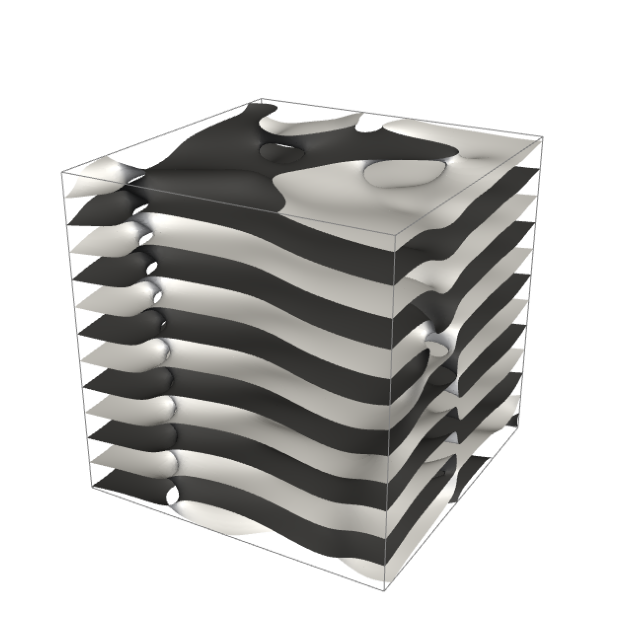

In [10]:
# Read the image file
img = image.imread('output.png')

fig = plt.figure(figsize=(4, 4),dpi=192)
ax = plt.subplot(1,1,1)
# Plot the image
ax.imshow(img)
plt.axis('off')
